In [35]:
import torch #import the library
import torch.nn.functional as F #for functions such as loss coputation
import matplotlib.pyplot as plt #for making figures
%matplotlib inline

In [36]:
# download the names.txt file from github in the english language
!wget https://raw.githubusercontent.com/noakraler/animal_names.txt/refs/heads/main/animal_names.txt

--2025-02-26 10:26:42--  https://raw.githubusercontent.com/noakraler/animal_names.txt/refs/heads/main/animal_names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11753 (11K) [text/plain]
Saving to: ‘animal_names.txt’

animal_names.txt    100%[===================>]  11.48K  --.-KB/s    in 0s      

2025-02-26 10:26:43 (99.3 MB/s) - ‘animal_names.txt’ saved [11753/11753]



In [37]:
words_en = open('animal_names.txt', 'r').read().splitlines() #open a file in read more and read the content of it, in addition split the file into a list with separted words
words_en = [word.replace("-", "").replace("'", "").replace(","," ").replace("’"," ").replace("."," ") for word in words_en] #replace/drop punctuation
words_en = [word.lower() for word in words_en] #lower all letters
words_en[:10] #show the first 10 words from the list



['aardvark',
 'albatross',
 'alligator',
 'alpaca',
 'anaconda',
 'angelfish',
 'ant',
 'anteater',
 'antelope',
 'armadillo']

In [38]:
len(words_en) # count the  number of words in the list

1044

In [39]:


# build the vocabulary of characters and mappings to/from integers (EN)
chars_en = sorted(list(set(''.join(words_en)))) #concatenates the words into a string, while organizing the characters into consisnt order
print(chars_en)
stoi_en = {s: i+1 for i, s in enumerate(chars_en)} #string to index
stoi_en['.'] = 0
# Remove numerical keys from stoi_en
stoi_en = {k: v for k, v in stoi_en.items() if not k.isdigit()} # Filter out numerical keys
print(stoi_en)
itos_en = {i: s for s, i in stoi_en.items()} #index to string
print(itos_en)


# build the dataset  in english
block_size = 3 #context length

def build_dataset(words_en): #converts the list of words into dataset
  X, Y = [], []
  for w in words_en:


    context = [0] * block_size #intializes a vector of length 3 into zeros
    for ch in w + '.': #adds a period in the end of words
      ix = stoi_en[ch] # get the index of the current character from stoi_en
      X.append(context) #previous 3 characters
      Y.append(ix) #next characters
      context = context[1:] + [ix] # crop and append

#tensor data formeat
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y #return to dateset

import random
random.seed(42) # make sure the the random shuffle is consistent
random.shuffle(words_en)
n1 = int(0.8*len(words_en)) #for training
n2 = int(0.9*len(words_en)) #for validation

Xtr_en, Ytr_en = build_dataset(words_en[:n1]) # Define Xtr_en, Ytr_en - convert to numerical -traning set
Xdev, Ydev = build_dataset(words_en[n1:n2])   #validation set
Xte, Yte = build_dataset(words_en[n2:]) #test set

 # tensor into a 1D list
all_chars_in_Xtr_en = set(Xtr_en.flatten().tolist())

#finding missing characters
missing_chars = all_chars_in_Xtr_en - set(stoi_en.keys())

#adding special characters
next_index = max(stoi_en.values()) + 1
for char in missing_chars:
    stoi_en[char] = next_index
    next_index += 1


#Add handling for unknown characters
max_index_in_Xtr_en = torch.max(Xtr_en) # find the biggest index
if max_index_in_Xtr_en >= len(stoi_en): #find any character not in vocabulary
    print(f"Warning: Xtr contains indices greater than vocabulary size. Max index in Xtr: {max_index_in_Xtr_en}, Vocabulary size: {len(stoi_en)}")
    Xtr_en[Xtr_en >= len(stoi_en)] = 0 # replace unknown characters with a special token





[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, '.': 0}
{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}
torch.Size([9374, 3]) torch.Size([9374])
torch.Size([1225, 3]) torch.Size([1225])
torch.Size([1119, 3]) torch.Size([1119])


In [40]:

g_en = torch.Generator().manual_seed(2147483647) # for reproducibility
C_en = torch.randn((80, 10), generator=g_en) #create a random embedding matrix ' 80 rows and 10 columns
W1_en = torch.randn((30, 200), generator=g_en) #take 30 values and map them to 200 neurons
b1_en = torch.randn(200, generator=g_en) #add a 200 size vector to each neuron
W2_en = torch.randn((200, 80), generator=g_en) #take 200 from first layer and maps to 80 outputs
b2_en = torch.randn(80, generator=g_en) #add 80 size vactor
parameters_en = [C_en, W1_en, b1_en, W2_en, b2_en] #grop the parameters into a list

In [41]:
sum(p.nelement() for p in parameters_en) # number of parameters in total in english

23080

In [42]:
#track gradients
for p in parameters_en:
  p.requires_grad = True

In [43]:
#create a range of learning rates
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [44]:
#here are enpty lists to store:
lri = [] #learning rate
lossi = [] #loss values
stepi = [] # traning steps

In [45]:
for i in range(200000):
    #  Sample a random mini-batch of 32 examples
    ix = torch.randint(0, Xtr_en.shape[0], (32,))

    # Forward pass
    emb = C_en[Xtr_en[ix]]  # (32, 3, embedding_dim)
    h = torch.tanh(emb.view(-1, 30) @ W1_en + b1_en)
    logits = h @ W2_en + b2_en
    loss = F.cross_entropy(logits, Ytr_en[ix])  # Cross-entropy loss

    #  Backward pass (reset gradients, then compute new ones)
    for p in parameters_en:
        p.grad = None
    loss.backward()

    #  Update parameters (simple gradient descent)
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters_en:
        p.data -= lr * p.grad

    # Track stats (for plotting/analysis)
    stepi.append(i)
    lossi.append(loss.log10().item())


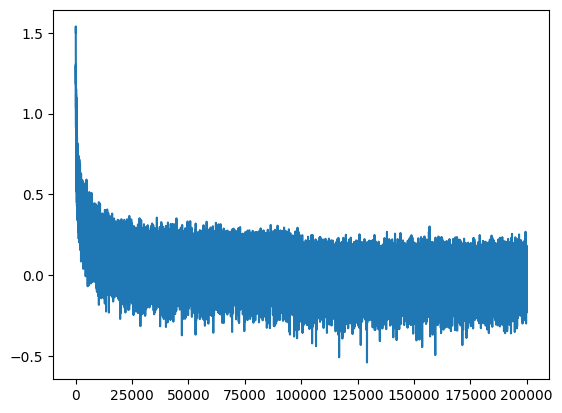

In [46]:
plt.plot(stepi, lossi)   # Plots the training loss over time (x-axis: stepi, y-axis: lossi)

In [47]:
# training loss
emb = C_en[Xtr_en] #retrive the embedding
h = torch.tanh(emb.view(-1, 30) @ W1_en + b1_en) #linar transformation  and tanh activation
logits = h @ W2_en + b2_en #complete logits
loss = F.cross_entropy(logits, Ytr_en)  #crentropyoss
loss #show the loss

tensor(1.0071, grad_fn=<NllLossBackward0>)

In [48]:
# validation loss
emb = C_en[Xdev] # retrieve the embeddings
h = torch.tanh(emb.view(-1, 30) @ W1_en + b1_en)  #linar transformation  and tanh activation
logits = h @ W2_en + b2_en  #complete logits
loss = F.cross_entropy(logits, Ydev)  #crentropyoss
loss #show loss

tensor(2.8659, grad_fn=<NllLossBackward0>)

In [49]:
# test loss
emb = C_en[Xte] #  retrieve the embeddings
h = torch.tanh(emb.view(-1, 30) @ W1_en + b1_en) # linar transformation  and tanh activation
logits = h @ W2_en + b2_en #complete logits
loss = F.cross_entropy(logits, Yte)  #crentropyoss
loss #show loss

tensor(2.5703, grad_fn=<NllLossBackward0>)

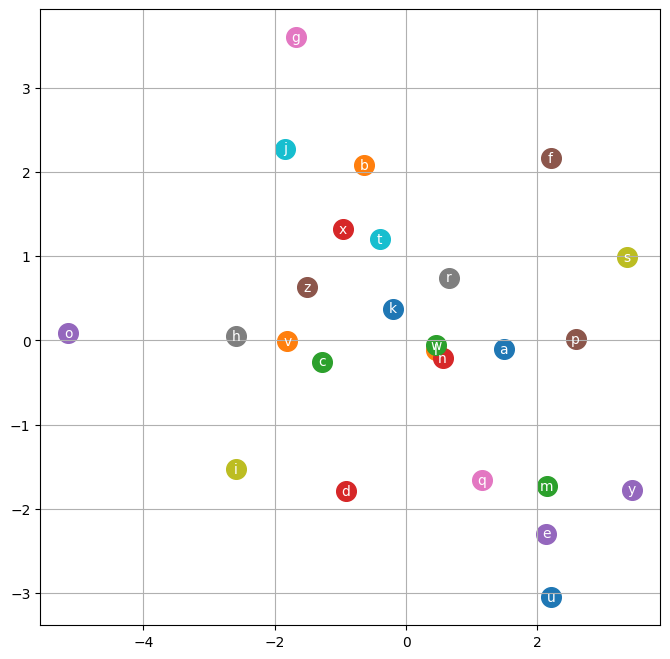

In [51]:
plt.figure(figsize=(8,8))  # Create an 8x8 figure

for i in range(C_en.shape[0]):  # Loop over each row in C_en
    letter = itos_en.get(i, "")  # Get the corresponding letter, defaulting to empty string
    if letter in ["", " ", "."]:  # Skip if letter is empty, space, or a period
        continue

    plt.scatter(C_en[i, 0].item(), C_en[i, 1].item(), s=200)  # Plot a point at the coordinates
    plt.text(C_en[i, 0].item(), C_en[i, 1].item(), letter,
             ha="center", va="center", color='white')  # Label the point with the letter

plt.grid('minor')  # Add a minor grid
plt.show()  # Display the plot


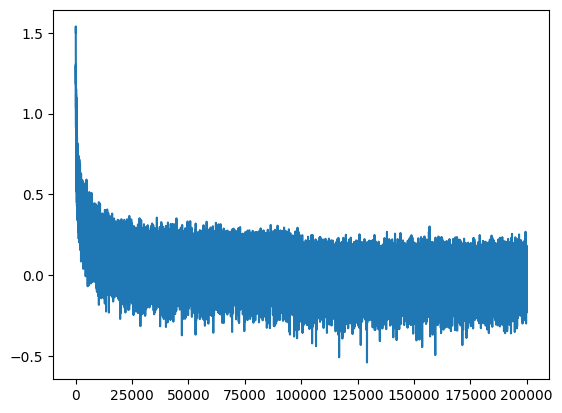

In [52]:
plt.plot(stepi, lossi)  # Plots the training loss over time (x-axis: stepi, y-axis: lossi)

In [56]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10) #set a random seed

for _ in range(20): #generate 20 names

    out = [] # make an empty list to store generated names
    context = [0] * block_size # initialize with all zeros
    while True: #keep generating
      emb = C_en[torch.tensor([context])] # (retrieve the embeddings
      h = torch.tanh(emb.view(1, -1) @ W1_en + b1_en) #comute hidden layer activation with tanh
      logits = h @ W2_en + b2_en # compute final output layer
      probs = F.softmax(logits, dim=1) #apply softmax
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() #sample the next character with the right probability
      context = context[1:] + [ix] #update the context
      out.append(ix) #store the charcter to outpot list
      if ix == 0: #when reacing the stop token ,stop generating
        break

    # Handle unknown characters during name generation
    print(''.join(itos_en.get(i, '<UNK>') for i in out)) # If i is not in itos_en, use '<UNK>' instead

asp.
blue jay.
dusky dolphiuma.
bigmiever.
spider.
dog.
gret.
oo<UNK>astern beardvark.
aspider beardeaux.
cockher.
binteat danian treetah.
fiddlefishephanther.
puma.
tigerian elephant.
tasmander.
minkajou.
dungle.
euraselligator.
fossum.
elk.


the spanish model

In [57]:
import torch #import the library
import torch.nn.functional as F #for functions such as loss coputation
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [58]:
# download the names.txt file from github in Spanish
!wget https://raw.githubusercontent.com/noakraler/animal_names.txt/refs/heads/main/animal_spanish.txt

--2025-02-26 10:30:35--  https://raw.githubusercontent.com/noakraler/animal_names.txt/refs/heads/main/animal_spanish.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20488 (20K) [text/plain]
Saving to: ‘animal_spanish.txt.1’

animal_spanish.txt. 100%[===================>]  20.01K  --.-KB/s    in 0.001s  

2025-02-26 10:30:36 (36.8 MB/s) - ‘animal_spanish.txt.1’ saved [20488/20488]



In [59]:
words_sp = open('animal_spanish.txt', 'r').read().splitlines() # Opens a file named 'animal_spanish.txt' in read mode ('r'), reads its entire content, and splits it into a list of lines. Each line is stored as an element in the 'words_sp' list.
words_sp = [word.replace("-", "").replace("'", "").replace(","," ") for word in words_sp] # Iterates through each word in the 'words_sp' list and removes hyphens, apostrophes, and replaces commas with spaces. The cleaned words are collected into a new list, which is assigned back to 'words_sp'.
words_sp = [word.lower() for word in words_sp] # Converts all words in the 'words_sp' list to lowercase.
words_sp[:8] # Displays the first 8 elements of the 'words_sp' list, likely for visual verification of the data.

['abeja',
 'águila',
 'albatros',
 'alce',
 'almeja',
 'anaconda',
 'anguila',
 'antílope']

In [60]:
len(words_sp) #count words

1052

In [61]:
# build the vocabulary of characters and mappings to/from integers (SP)
chars_sp = sorted(list(set(''.join(words_sp))))  #concatenates the words into a string, while organizing the characters into consisnt order
stoi_sp = {s:i+1 for i,s in enumerate(chars_sp)}  #string to index
stoi_sp['.'] = 0   #index to string
itos_sp = {i:s for s,i in stoi_sp.items()}
print(itos_sp)


# build the dataset in Spanish
block_size = 3 # context length
def build_dataset(words_sp): #converts the list of words into dataset
  X, Y = [], []
  for w in words_sp:

    context = [0] * block_size  #intializes a vector of length 3 into zeros
    for ch in w + '.':    #adds a period in the end of words
      ix = stoi_sp[ch]   #characters to numerical index
      X.append(context)  #previous 3 characters
      Y.append(ix)    #next characters

      context = context[1:] + [ix] # crop and append

#tensor data formeat
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y  #return to dateset


import random
random.seed(42)  #make sure the the random shuffle is consistent
random.shuffle(words_sp)
n1 = int(0.8*len(words_sp))  #for training
n2 = int(0.9*len(words_sp))   #for validation

Xtr_sp, Ytr_sp = build_dataset(words_sp[:n1])  # Define Xtr_en, Ytr_en - convert to numerical -traning set
Xdev_sp, Ydev_sp = build_dataset(words_sp[n1:n2])  #validation set
Xte_sp, Yte_sp = build_dataset(words_sp[n2:])    #test set


#Add handling for unknown characters
max_index_in_Xtr_sp  = torch.max(Xtr_sp) # find the biggest index
if max_index_in_Xtr_sp >= len(stoi_sp): #find any character not in vocabulary

    print(f"Warning: Xtr_sp contains indices greater than vocabulary size. Max index in Xtr: {max_index_in_Xtr_sp}, Vocabulary size: {len(stoi_sp)}")
    # Option 1: Replace unknown indices with a special token (e.g., 0 for unknown)
    Xtr_sp[Xtr_sp >= len(stoi_sp)] = 0 ## replace unknown characters with a special token





{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'á', 29: 'é', 30: 'í', 31: 'ñ', 32: 'ó', 33: 'ú', 34: 'ü', 0: '.'}
torch.Size([16046, 3]) torch.Size([16046])
torch.Size([2079, 3]) torch.Size([2079])
torch.Size([1905, 3]) torch.Size([1905])


In [62]:
# build the dataset

block_size = 3  # The model will consider the previous 3 characters to predict the next one

# Function to build the dataset (X: input, Y: target)
def build_dataset(words_sp):
  X, Y = [], []  # Initialize empty lists for input and target
  for w in words_sp:  # Iterate through each word
    context = [0] * block_size  # Initialize the context window with zeros (beginning of word)
    for ch in w + '.':  # Iterate through each character in the word (plus a period at the end)
      ix = stoi_sp[ch]  # Get the index of the current character
      X.append(context)  # Add the current context to the input list
      Y.append(ix)  # Add the index of the next character to the target list
      context = context[1:] + [ix]  # Update the context window (shift and add current character)

  X = torch.tensor(X)  # Convert the input list to a PyTorch tensor
  Y = torch.tensor(Y)  # Convert the target list to a PyTorch tensor
  print(X.shape, Y.shape)  # Print the shapes of the tensors
  return X, Y  # Return the input and target tensors


# Set a random seed for reproducibility
random.seed(42)
random.shuffle(words_sp)  # Shuffle the words randomly

# Calculate indices to split the data into training, validation, and test sets
n1 = int(0.8*len(words_sp))  # 80% for training
n2 = int(0.9*len(words_sp))  # 10% for validation, 10% for testing

# Create the datasets
Xtr_sp, Ytr_sp = build_dataset(words_sp[:n1])  # Training set
Xdev_sp, Ydev_sp = build_dataset(words_sp[n1:n2])  # Validation set
Xte_sp, Yte_sp = build_dataset(words_sp[n2:])  # Test set

torch.Size([15795, 3]) torch.Size([15795])
torch.Size([2114, 3]) torch.Size([2114])
torch.Size([2121, 3]) torch.Size([2121])


In [63]:
g_sp = torch.Generator().manual_seed(2147483647) # for reproducibility
C_sp = torch.randn((80, 10), generator=g_sp) #create a random embedding matrix ' 80 rows and 10 columns
W1_sp = torch.randn((30, 200), generator=g_sp) #take 30 values and map them to 200 neurons
b1_sp = torch.randn(200, generator=g_sp)  #add a 200 size vector to each neuron
W2_sp = torch.randn((200, 80), generator=g_sp) #take 200 from first layer and maps to 80 outputs
b2_sp = torch.randn(80, generator=g_sp)  #add 80 size vactor
parameters_sp = [C_sp, W1_sp, b1_sp, W2_sp, b2_sp]  #grop the parameters into a list

In [64]:
sum(p.nelement() for p in parameters_sp) # number of parameters in total in spanish

23080

In [65]:
#track gradients
for p in parameters_sp:
  p.requires_grad = True

In [78]:
# empty lists to store:

lri = [] #learning rate
lossi = [] #loss values
stepi = []# traning steps

In [67]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr_sp.shape[0], (32,))

  # forward pass
  emb = C_sp[Xtr_sp[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1_sp + b1_sp)
  logits = h @ W2_sp + b2_sp
  loss = F.cross_entropy(logits, Ytr_sp[ix])

  # backward pass
  for p in parameters_sp:
    p.grad = None
  loss.backward()


  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters_sp:
    p.data += -lr * p.grad

  stepi.append(i)
  lossi.append(loss.log10().item())



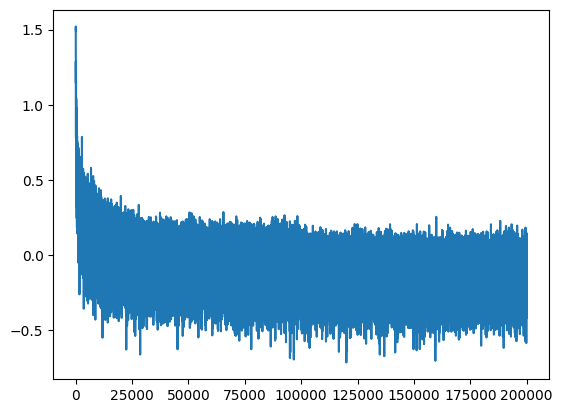

In [68]:
plt.plot(stepi, lossi)

In [69]:
# training loss
emb = C_sp[Xtr_sp] ##retrive the embedding
h = torch.tanh(emb.view(-1, 30) @ W1_sp + b1_sp) #linar transformation  and tanh activation
logits = h @ W2_sp + b2_sp # (32, 27) #complete logits
loss = F.cross_entropy(logits, Ytr_sp) #crentropyoss
loss #show the loss

tensor(0.7783, grad_fn=<NllLossBackward0>)

In [70]:
 #validation loss
emb = C_sp[Xdev_sp] # retrieve the embeddings
h = torch.tanh(emb.view(-1, 30) @ W1_sp + b1_sp)  #linar transformation  and tanh activation
logits = h @ W2_sp + b2_sp  #complete logits
loss = F.cross_entropy(logits, Ydev_sp)  #crentropyoss
loss #show loss

tensor(1.4323, grad_fn=<NllLossBackward0>)

In [71]:
# test loss
emb = C_sp[Xte_sp] #  retrieve the embeddings
h = torch.tanh(emb.view(-1, 30) @ W1_sp + b1_sp) # linar transformation  and tanh activation
logits = h @ W2_sp + b2_sp #complete logits
loss = F.cross_entropy(logits, Yte_sp)  #crentropyoss
loss #show loss

tensor(1.4511, grad_fn=<NllLossBackward0>)

In [72]:
print("Characters in stoi_sp:", stoi_sp) # check the character-to-index mapping


Characters in stoi_sp: {' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'á': 28, 'é': 29, 'í': 30, 'ñ': 31, 'ó': 32, 'ú': 33, 'ü': 34, '.': 0}


In [73]:
# Check for missing indices in the Spanish character mapping (itos_sp)
missing_chars = []  # List to store indices that are not present in itos_sp

# Loop through every possible index based on the Spanish embedding matrix dimensions
for i in range(C_sp.shape[0]):
    # If an index is missing in the mapping, add it to missing_chars
    if i not in itos_sp:
        missing_chars.append(i)

# Print out the missing indices for debugging purposes
print("Missing characters in itos_sp:", missing_chars)


Missing characters in itos_sp: [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


In [74]:
# adding the missing characters
missing_chars = [35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]

for char_index in missing_chars:
    itos_sp[char_index] = "?"  # adding general sign to unknown characters

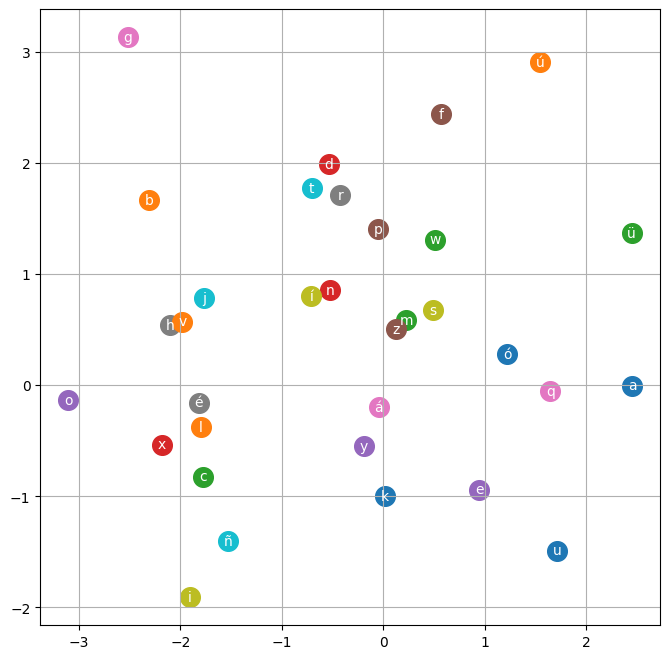

In [79]:
plt.figure(figsize=(8,8))  # Create a figure with size 8x8 inches

for i in range(C_sp.shape[0]):  # Iterate over each row in C_sp
    letter = itos_sp.get(i, "")  # Get the corresponding letter; if none, use an empty string

    letter = letter.replace("?", "")  # Remove any question marks from the letter

    # If the letter is empty, a space, or just a period, skip it
    if letter in ["", " ", "."]:
        continue

    # Plot a point at the (x, y) coordinates in C_sp for the current row
    plt.scatter(C_sp[i, 0].item(), C_sp[i, 1].item(), s=200)

    # Place the letter text at the same coordinates, centered horizontally and vertically, in white
    plt.text(C_sp[i, 0].item(), C_sp[i, 1].item(),
             letter,
             ha="center", va="center", color='white')

plt.grid('minor')  # Add minor grid lines to the plot
plt.show()  # Display the plot


In [80]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10) #set a random seed

for _ in range(20):  #generate  names

    out = [] # make an empty list to store generated names
    context = [0] * block_size ## initialize with all zeros
    while True: #keep generating
      emb = C_sp[torch.tensor([context])] # retrieve the embeddings
      h = torch.tanh(emb.view(1, -1) @ W1_sp + b1_sp) #compute hidden layer activation with tanh
      logits = h @ W2_sp + b2_sp  # compute final output layer
      probs = F.softmax(logits, dim=1) #apply softmax
      ix = torch.multinomial(probs, num_samples=1, generator=g).item() #sample the next character with the right probability
      context = context[1:] + [ix] #update the context
      out.append(ix)  #store the charcter to outpot list
      if ix == 0:  #when reacing the stop token ,stop generating
        break

    print(''.join(itos_sp[i] for i in out))

anguila minodimensional.
araña paipárino.
cigante.
halo onistadoraldimensionastruenodimensional.
cotorde.
bicho zigzagueo nebulón de limónico gra.
angre japonegra.
bicho zigzagueo inte.
cotorrita nebuloso.
cernícanacolos borestial.
agueo ámbarritán.
cotorrita.
cisne roso.
cisne negro.
escupido.
bicho zigzagueo volado.
col gigar.
ballo.
atún del amayónges.
bicho zigzagueo volcánico unives.


part two
after buliding  and traning the two models in english and spanish to learn  the strecure and patterns of each language, the next step is to eveluate id they can apply the rules they learned in one language and generated words in the other language.this stap will test the models ability to transfer linguistics knowledge between languages


In [81]:
def evaluate_model(X, Y, C, W1, b1, W2, b2): # take different parameters and caculated the loss for the dataset : x-input data , y- targat data ,c- embadding matrix, w1+b1-first layer, w2+b2- second layer

    emb = C[X] # retrieved the character embedding  for x from c
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # to make the embedding go trough to first layer
    logits = h @ W2 + b2 # h(transfered data) is passed through the second layer
    loss = F.cross_entropy(logits, Y) #compute loss between logits and Y
    return loss #returen evaluation of loss
#eveluating english model on english data
loss_en = evaluate_model(Xtr_en, Ytr_en, C_en, W1_en, b1_en, W2_en, b2_en) # caculate the loss of english model on english data
print(f"Evaluating English model loss on English data: {loss_en}")

#eveluating spanish model on spanish data
loss_sp = evaluate_model(Xtr_sp, Ytr_sp, C_sp, W1_sp, b1_sp, W2_sp, b2_sp) # caculate the loss of spanish  model on spanish data
print(f"Evaluating Spanish model loss on Spanish data: {loss_sp}")

Evaluating English model loss on English data: 1.0071405172348022
Evaluating Spanish model loss on Spanish data: 0.7783129811286926


In [82]:
#eveluating english model on spanish data
loss_en_on_sp = evaluate_model(Xtr_sp, Ytr_sp, C_en, W1_en, b1_en, W2_en, b2_en) # caculate the loss of english model on spanish  data
print(f"Evaluating English model loss on Spanish data: {loss_en_on_sp}")

#eveluating spanish model on english  data
loss_sp_on_en = evaluate_model(Xtr_en, Ytr_en, C_sp, W1_sp, b1_sp, W2_sp, b2_sp) # caculate the loss of spanish model on english data
print(f"Evaluating Spanish model loss on English data: {loss_sp_on_en}")


Evaluating English model loss on Spanish data: 9.177797317504883
Evaluating Spanish model loss on English data: 8.163227081298828


In [83]:
import torch  # Import PyTorch library
import torch.nn.functional as F  # Import PyTorch's neural network functions

def generate_names(C, W1, b1, W2, b2, itos, num_names=10, block_size=3):
    # Create a random generator with a fixed seed for reproducibility
    g = torch.Generator().manual_seed(2147483647 + 10)
    generated_names = []  # List to store the generated names

    for _ in range(num_names):
        out = []  # List to store the output indices for the current name
        context = [0] * block_size  # Initialize the context with zeros (start tokens)
        while True:
            # Retrieve embeddings for the current context; result shape: (1, block_size, embedding_dim)
            emb = C[torch.tensor([context])]
            # Flatten the embeddings and compute the hidden layer activation with tanh
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            # Compute output logits from the hidden layer
            logits = h @ W2 + b2
            # Convert logits to probabilities using softmax
            probs = F.softmax(logits, dim=1)
            # Sample an index from the probability distribution
            ix = torch.multinomial(probs, num_samples=1, generator=g).item()
            # Update the context by removing the oldest index and adding the new one
            context = context[1:] + [ix]
            out.append(ix)  # Append the sampled index to the output sequence
            # Stop if the sampled index is 0 (assumed to be the end-of-name token)
            if ix == 0:
                break

        # Convert the sequence of indices into characters and join them to form the name
        generated_names.append(''.join(itos[i] for i in out))

    return generated_names  # Return the list of generated names


In [84]:
# in this part we can see the generated names since they are generated only from the "itos_sp' that inculde all the characters
print("Generating Spanish names with English model...")
generate_names(C_en, W1_en, b1_en, W2_en, b2_en, itos_sp, num_names=10) # Using itos_sp for Spanish names


print("Generating English names with Spanish model...")
generate_names(C_sp, W1_sp, b1_sp, W2_sp, b2_sp, itos_sp, num_names=10) # Using itos_sp, not itos_en

Generating Spanish names with English model...
Generating English names with Spanish model...


['anguila minodimensional.',
 'araña paipárino.',
 'cigante.',
 'halo onistadoraldimensionastruenodimensional.',
 'cotorde.',
 'bicho zigzagueo nebulón de limónico gra.',
 'angre japonegra.',
 'bicho zigzagueo inte.',
 'cotorrita nebuloso.',
 'cernícanacolos borestial.']

In [85]:
# Attempt to generate Spanish names using the English model, and vice versa.
# Note: Since the English model's character mapping (itos_en) does not include certain Spanish characters,
# generating Spanish names with the English model (using itos_sp) is expected to fail.
print("Generating Spanish names with English model...")
generate_names(C_en, W1_en, b1_en, W2_en, b2_en, itos_sp, num_names=10)  # Using the Spanish mapping for names

# Attempt to generate English names with the Spanish model.
# This line is expected to throw an error because the Spanish model's mapping includes characters
# that are missing in the English mapping (itos_en).
print("Generating English names with Spanish model...")
generate_names(C_sp, W1_sp, b1_sp, W2_sp, b2_sp, itos_en, num_names=10)


Generating Spanish names with English model...
Generating English names with Spanish model...


KeyError: 31